Coleta dados de preços da soja, safra, uso e estoques

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats

from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

dateparse0 = lambda dates: [pd.to_datetime(d, format='%Y-%m-%d') for d in dates]
soy = pd.read_csv("input/soybean_nearby.txt")
soy["dates"] = pd.to_datetime(soy["dates"], format='%Y-%m-%d')
soy.index = soy["dates"]
del soy["dates"]

def get_SupplyUse( fname_proj, MktYrs ):
    ByYear_SupplyUse = {}
    WASDE_dtstrs = []
    for mktyr in MktYrs:
        data = pd.read_csv( "input/" + fname_proj + mktyr + ".csv" )
        data["date"] = pd.to_datetime(data["Date"])
        data.index = data['date']
        del data["date"]
        data["s2u"] = data["Ending Stocks"] / data["Total Use"]
        ByYear_SupplyUse[ mktyr ] = data
        WASDE_dtstrs = np.hstack( (WASDE_dtstrs, data["Date"].values) )
    return ByYear_SupplyUse, np.unique(WASDE_dtstrs)

SupplyUse, WASDE_dtStrs = get_SupplyUse( "USDAProj_Soybean_", ["2007to2008","2008to2009","2009to2010","2010to2011",\
                                                            "2011to2012","2012to2013","2013to2014","2014to2015",\
                                                            "2015to2016","2016to2017","2017to2018"])

Projeções do  Departamento de Agricultura dos Estados Unidos (USDA).




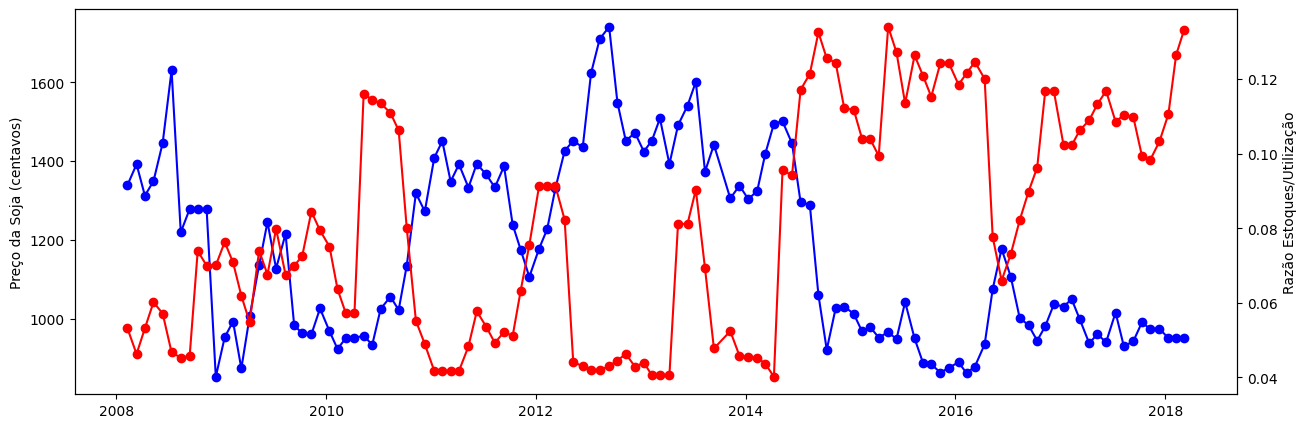

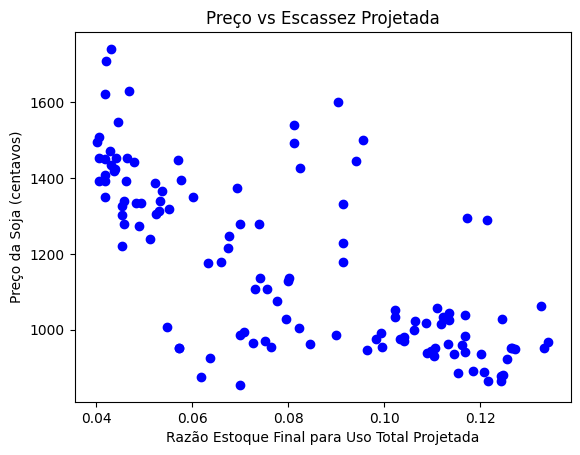

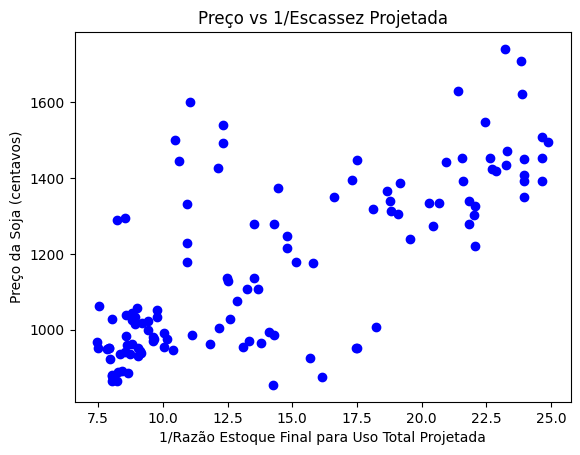

In [4]:
def corn_soy_mktyrs(dt1):
    if dt1.month < 5:
        NewCrop_mktyr = str(dt1.year - 1) + "to" + str(dt1.year)
        OldCrop_mktyr = str(dt1.year - 2) + "to" + str(dt1.year - 1)
    else:
        NewCrop_mktyr = str(dt1.year) + "to" + str(dt1.year + 1)
        OldCrop_mktyr = str(dt1.year - 1) + "to" + str(dt1.year)
    return [NewCrop_mktyr, OldCrop_mktyr]

Nearby = []
S2U = []
plot_dts = []
for dtstr in WASDE_dtStrs:
    Curr_dt = datetime.strptime(dtstr, "%Y/%m/%d")
    if Curr_dt > pd.to_datetime(soy.index[0]):
        new_crop_year, old_crop_year = corn_soy_mktyrs(Curr_dt)
        s2u = SupplyUse[new_crop_year]["s2u"][:Curr_dt][-1]
        S2U.append(s2u)
        Nearby.append(soy[:Curr_dt]["nearby_close"][-1])
        plot_dts.append(Curr_dt)

plt.subplots(figsize=(15,5))
plt.plot_date(plot_dts, Nearby, 'bo-')
plt.ylabel("Preço da Soja (centavos)")

ax2 = plt.twinx()
ax2.plot_date(plot_dts, S2U, 'ro-')
plt.xlabel('Data')
ax2.set_ylabel("Razão Estoques/Utilização")
plt.show()

InvS2U = np.divide(1.0, np.array(S2U))
plt.plot(S2U, Nearby, 'o', color="blue")
plt.xlabel("Razão Estoque Final para Uso Total Projetada")
plt.ylabel("Preço da Soja (centavos)")
plt.title("Preço vs Escassez Projetada")
plt.show()

plt.plot(InvS2U, Nearby, 'o', color="blue")
plt.xlabel("1/Razão Estoque Final para Uso Total Projetada")
plt.ylabel("Preço da Soja (centavos)")
plt.title("Preço vs 1/Escassez Projetada")
plt.show()


Considera análise de contratos individuais em vez de preços próximos.

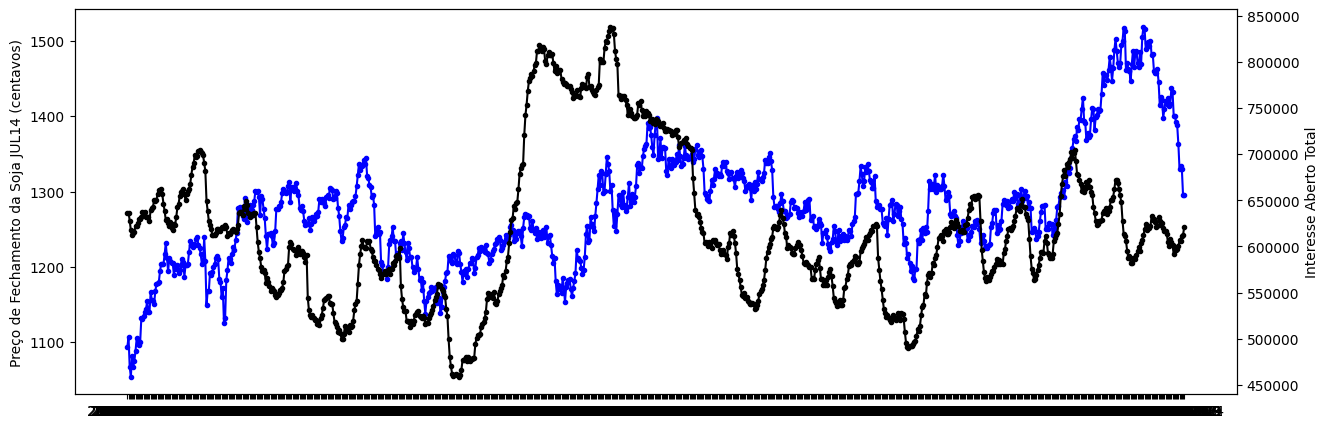

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

soy = pd.read_csv("input/soybean_JUL14.txt", index_col=0)

soy = soy.loc[soy["TotalOpenInt"] != 0]

plt.subplots(figsize=(15,5))
plt.plot_date(soy.index, soy["Close"], '.-', color="blue")
plt.ylabel("Preço de Fechamento da Soja JUL14 (centavos)")

ax2 = plt.twinx()
ax2.plot_date(soy.index, soy["TotalOpenInt"], '.-', color="black")
ax2.set_ylabel("Interesse Aberto Total")

plt.show()


Analisa correlação entre preços e TOI (atividade do mercado) usando correlação deslizante de Spearman.

In [6]:
df = soy[["Close", "TotalOpenInt"]].copy()
spearmanWindow = 10
spearmanVec = [ None for p in range(0,spearmanWindow)]
for ii in range(10, len(df["Close"])):
    newR = stats.spearmanr( df["Close"][ ii-10: ii], df["TotalOpenInt"][ ii-10: ii])[0]
    spearmanVec.append( newR )
df["Spearman"] = spearmanVec

Adiciona a proporção Estoque/Utilização (S2U) no conjunto de dados.




In [7]:
last_S2U = []
for ii in df.index:
    Curr_dt = pd.to_datetime(ii )
    new_crop_year, old_crop_year = corn_soy_mktyrs( Curr_dt  )
    s2u_new_vals = SupplyUse[ new_crop_year ]["s2u"][:ii]
    if len(s2u_new_vals ):
        s2u = s2u_new_vals[-1]
    else:
        s2u = SupplyUse[ old_crop_year ]["s2u"][:ii][-1]
    last_S2U.append( s2u )
df["S2U"] = last_S2U
df["InvS2U"] = df["S2U"].apply( lambda x: 1.0 / float( x ) )
df = df.iloc[ spearmanWindow:, :]
df.head(5)

,Close,TotalOpenInt,Spearman,S2U,InvS2U
dates,,,,,
2010-11-29,1096.0,629228.0,0.565352,0.055207,18.113514
2010-11-30,1100.0,629641.0,0.565352,0.055207,18.113514
2010-12-01,1132.0,631521.0,0.516720,0.055207,18.113514
2010-12-02,1131.0,637044.0,0.806061,0.055207,18.113514
2010-12-03,1135.0,635581.0,0.866667,0.055207,18.113514


Constrói modelo LSTM para prever preços com base em dados históricos (X dias anteriores).

In [8]:

def normalize_windows( window_data, colsToNormalize, colsNotNormalized ):
    normalized_data=[]
    normalizing_vals=[]
    for window in window_data:
        window_norm = np.empty_like(window)
        norm_vals = []
        for c in colsToNormalize:
            firstVal = float(window[0,c])
            norm_col = [ ((float(p) / firstVal ) - 1 ) for p in window[:,c]]
            window_norm[:,c] = norm_col
            norm_vals.append( firstVal )
        for cc in colsNotNormalized:
            window_norm[ :, cc ] = [ p for p in window[:,cc]]
        normalized_data.append( window_norm )
        normalizing_vals.append( norm_vals )
    return [ normalized_data, np.array(normalizing_vals) ]

def denormalize_windows( scValues, norm_values ):
    output = []
    for ii in range( scValues.shape[0]):
        scV_row = scValues[ii,:]
        norm_row = norm_values[ii]
        out_row = np.multiply( norm_row, scV_row + 1 )
        output.append( list(out_row) )
    return np.array(output )

data = df[["Close", "TotalOpenInt", "Spearman", "InvS2U"]].values
train_percent = 0.9
seq_len = 20
sequence_length = seq_len + 1
result = []
for index in range( len(data) - sequence_length):
    result.append( data[ index: index + sequence_length ])

result, norm_vals = normalize_windows( result, [0],  [1,2,3] )

Divide dados em conjuntos para treinamento e avaliação do modelo LSTM.

In [9]:
result = np.array( result )
row = round( train_percent * result.shape[0])

X_train = result[:int(row), :-1, 1:]
y_train = result[:int(row), -1, 0]
norm_vals_train = norm_vals[:int(row)]

X_test = result[ int(row):, :-1, 1:]
y_test = result[ int(row):, -1,  0]
norm_vals_test = norm_vals[int(row):]

scX = MinMaxScaler(feature_range=(-1,1))
dummyX = X_train.copy()
tallX = dummyX[0].copy()
for ii in range( 1, len(dummyX) ):
    tallX = np.append( tallX, dummyX[ii] , axis=0 )
scX.fit( tallX )

for ii in range( 0, len(X_train)):
    X_train[ii] = scX.transform( X_train[ii] )

for ii in range( 0, len(X_test)):
    X_test[ii] = scX.transform( X_test[ii] )

scY = MinMaxScaler()
y_train = scY.fit_transform( y_train.reshape(-1,1) )
y_test = scY.transform( y_test.reshape(-1,1) )

Constrói um modelo LSTM








In [10]:
def build_model( layers ):
    dropout = 0.2
    model = Sequential()
    model.add(LSTM(50, input_shape=(layers[0], layers[1]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(32, kernel_initializer="uniform", activation="relu"))
    model.add(Dense(1, kernel_initializer="uniform", activation="linear"))

    model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])
    return model

model = build_model( [X_train.shape[1], X_train.shape[2],  1 ])

model.fit( X_train, y_train, batch_size=32, epochs=100)
y_pred = model.predict( X_test )

Epoch 1/100
25/25 [==============================] - 4s 13ms/step - loss: 0.1988 - accuracy: 0.0000e+00
Epoch 2/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0370 - accuracy: 0.0013
Epoch 3/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0286 - accuracy: 0.0013
Epoch 4/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0271 - accuracy: 0.0025
Epoch 5/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0281 - accuracy: 0.0013
Epoch 6/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0273 - accuracy: 0.0000e+00
Epoch 7/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0267 - accuracy: 0.0025
Epoch 8/100
25/25 [==============================] - 0s 13ms/step - loss: 0.0265 - accuracy: 0.0013
Epoch 9/100
25/25 [==============================] - 0s 14ms/step - loss: 0.0269 - accuracy: 0.0013
Epoch 10/100
25/25 [==============================] - 0s 19ms/step - loss: 0.0256 - accuracy

Analisa a forma da saída do modelo LSTM

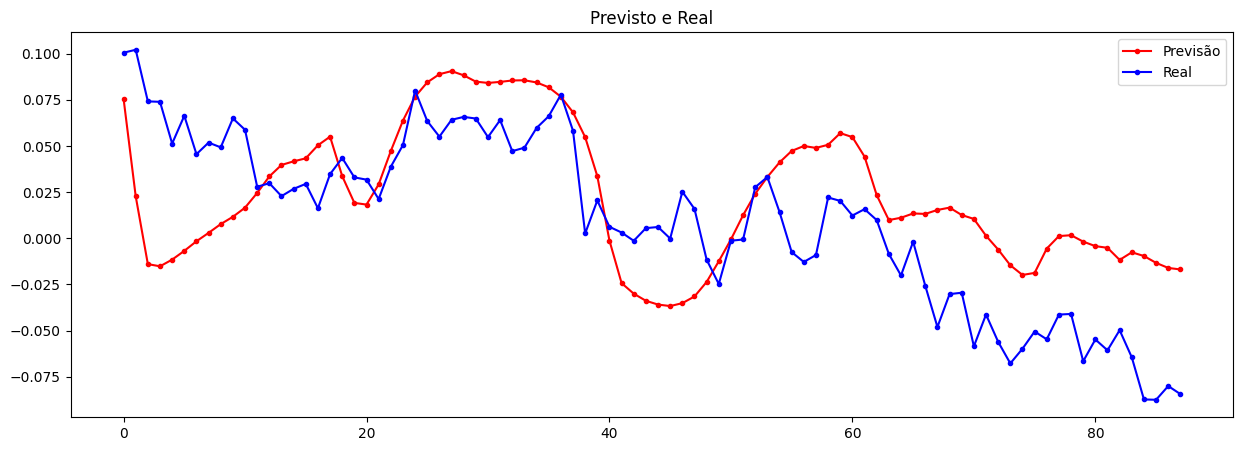

In [11]:
invSc_YPred = scY.inverse_transform(y_pred)
invSc_Y_test = scY.inverse_transform(y_test)


plt.subplots(figsize=(15, 5))
plt.plot(invSc_YPred, marker=".", color="red", label="Previsão")
plt.plot(invSc_Y_test, marker=".", color="blue", label="Real")
plt.legend(loc="best")
plt.title("Previsto e Real")
plt.show()


Converte a saída do modelo de volta para a escala de preços reais.

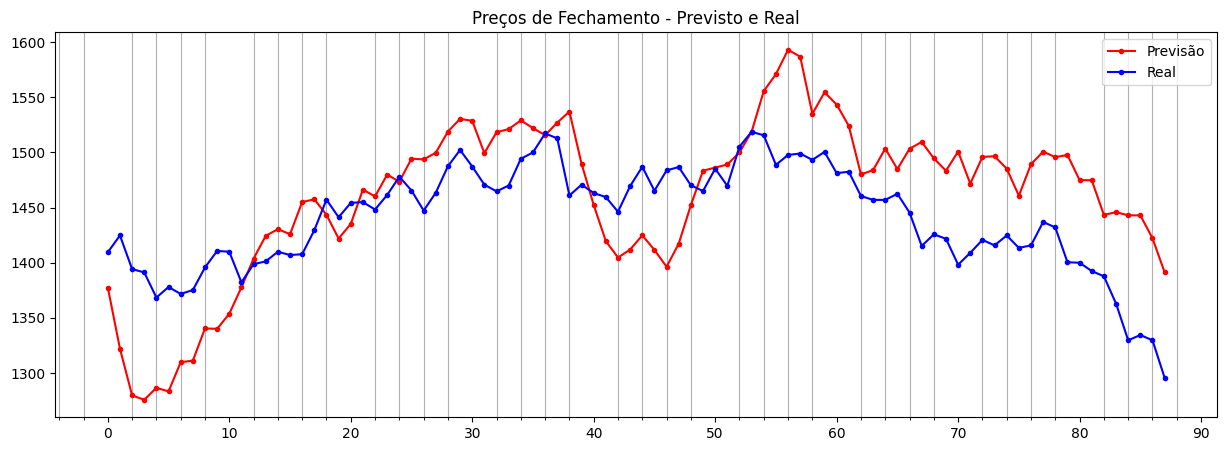

In [12]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

inv_y_test = denormalize_windows(invSc_Y_test, norm_vals_test)
inv_y_test_pred = denormalize_windows(invSc_YPred, norm_vals_test)

plt.subplots(figsize=(15, 5))
plt.plot(inv_y_test_pred, marker='.', color="red", label="Previsão")
plt.plot(inv_y_test, marker='.',  color="blue", label="Real")
plt.legend(loc="best")
plt.title("Preços de Fechamento - Previsto e Real")
ax = plt.gca()
majorLocator = MultipleLocator(10)
majorFormatter = FormatStrFormatter('%d')
minorLocator = MultipleLocator(2)
ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)

ax.xaxis.set_minor_locator(minorLocator)
ax.grid(which="minor")
plt.show()
